# Creating Custom Captum.optim Modules
Captum's Optim library contains an extensive list of optimization objectives, transforms, and input parameterizations. However, some cases may require adding new features to these areas of Captum's Optim library. Luckily adding them to Captum is easy!

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

# Custom Transforms

If both Captum and Torchvision lack the transforms that you require, then you can create your own custom transforms.

Custom transform classes must contain a `forward()` function. The first transform in a list of transforms takes an input tensor with a shape of (B, C, W, H), and the final transform in a list of transforms will need to output a tensor with the same shape of (B, C, W, H). Captum and Torchvision's transforms normally expect and output a shape of (B, C, W, H).

An optional `__init__()` function can be used as well.


Note that any custom transforms need sure that your transform is autograd compatible, so that the gradient is not interrupted during the optimization process.


In [3]:
class CustomTransform(torch.nn.Module):
    def __init__(self, val: int = 1) -> None:
        super(CustomTransform, self).__init__()
        self.val = val

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * self.val

# Custom Loss Functions
Captum's loss functions are composed of classes that the optimization function uses. Custom loss classes should inherit the base the loss class.

Custom loss functions must contain the following two functions:


* The `__init__()` function with that must at least contain a target variable. The target variable should be an nn.module or list of nn.modules to collect activations from. Other variables can be added after the target.

* The `__call__()` function which takes activations from the target layer and then returns a loss value.

In [4]:
class CustomLoss(optimviz.loss.Loss):
    def __init__(self, target: torch.nn.Module):
        super(optimviz.loss.Loss, self).__init__()
        self.target = target

    def __call__(self, target_activations):
        activations = target_activations[self.target] #  Get activations from target
        return activations

# Custom Input Parameterization


The tensor parameters that Captum's Optim library optimizes to produce visualizations is stored in a custom parameterization class. 

Custom parameterization must contain the following two functions:

An `__init__()` function with 3 input variables:

* size (tuple, int): dimensions in the form height, width. 

* channels (int): the number of channels for the output tensor.

* batch (int): the desired batch size to use.

* init (torch.Tensor): An optional input tensor with a shape of: (B, C, W, H).


A `forward()` function with zero input varibles that returns an `torch.nn.Parameter` version of the tensor being optimized, with its shape dimensions properly named for Captum. The output tensor for the forward function must already be converted to a `torch.nn.Parameter` tensor before the forward function is run.

In [5]:
class CustomInput(optimviz.images.ImageParameterization):
    def __init__(self, size = None, channels: int = 3, batch: int = 1, init = None) -> None:
        super().__init__()
        assert size is not None
        if init is None:
            init = torch.randn([batch, channels, size[0], size[1]]) #  Create random input with a shape of: B, C, W, H
        self.image = torch.nn.Parameter(init) #  Convert input to nn.Parameter()

    def forward(self) -> torch.Tensor:
        return self.image.refine_names("B", "C", "H", "W") #  rename dimensions


# Running Captum with custom modules

Below is a helper function that will let us quickly and easily experiment with our custom modules from above. Random scaling and random spatial jitter transforms are also included in the helper function to improve output quality.

In [9]:
def visualize(model, target, channel=5):
    image_param = CustomInput  # Define our custom input parameterization, then add it to NaturalImage
    image = optimviz.images.NaturalImage(size=(224, 224), Parameterization=image_param).to(device)
    transforms = torch.nn.Sequential(
        CustomTransform(),  # Add our custom transform the list of transforms

        #  Additional transforms to improve output quality
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    )
    loss_fn = CustomLoss(target) #  Define our custom loss function as the loss function
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


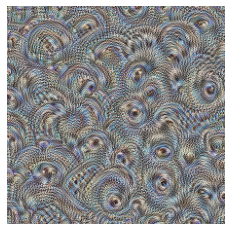

In [10]:
visualize(model, model.mixed4a, 476)